In [1]:
from pathlib import Path
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import fastai
from fastai.text import *

In [2]:
DATA_PATH = Path('../data')
tqdm_notebook().pandas()

In [3]:
text_cols = ['title', 'text']

In [4]:
train_df = pd.read_csv(DATA_PATH/'X_train_ftfy_nfkd.csv').fillna('xxempty')
valid_df = pd.read_csv(DATA_PATH/'X_valid_ftfy_nfkd.csv').fillna('xxempty')
test_df = pd.read_csv(DATA_PATH/'X_test_ftfy_nfkd.csv').fillna('xxempty')
# unlabeled_df = pd.read_csv(DATA_PATH/'X_unlabeled_ftfy_nfkd.csv').fillna('xxempty')

In [5]:
full_unlabeled_df = pd.concat([train_df[text_cols], valid_df[text_cols], test_df[text_cols]], # unlabeled_df[text_cols]], 
                              axis=0, ignore_index=True)
full_unlabeled_df.to_csv(DATA_PATH/'full_unlabeled.csv', index=False, header=True)

full_train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)
full_train_df.to_csv(DATA_PATH/'full_train.csv', index=False, header=True)

test_df.to_csv(DATA_PATH/'full_test.csv', index=False, header=True)

In [6]:
BOS,EOS,FLD,UNK,PAD = 'xxbos','xxeos','xxfld','xxunk','xxpad'
TK_MAJ,TK_UP,TK_REP,TK_WREP = 'xxmaj','xxup','xxrep','xxwrep'
EMPTY = 'xxempty'
text_spec_tok = [UNK,PAD,BOS,EOS,FLD,TK_MAJ,TK_UP,TK_REP,TK_WREP] + [EMPTY]

tokenizer = Tokenizer(special_cases=text_spec_tok)
tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

In [7]:
# data_lm.save(DATA_PATH/'data_lm_export.pkl')
data_lm = load_data(DATA_PATH, 'data_lm_export.pkl')

In [10]:
data_lm.show_batch()

idx,text
0,"is the "" force of nature "" xxmaj america needs to move on from the past three decades of its adherence to globalist policies and principles . xxmaj the veteran actor and xxmaj breitbart xxmaj news contributor began his speech by asking how many xxup cpac attendees were xxmaj trump supporters from the very first day he announced — a few raised their hands . xxmaj when he asked how"
1,"few months , xxmaj house xxup gop moderates who have been uncomfortable with their party 's xxmaj obamacare repeal bill have had the raucous complaints of xxmaj house conservative hardliners about the legislation to hide behind . xxmaj but that shield has fallen , the hardliners are supporting the bill , and now it 's the votes of xxmaj republicans from purple and blue districts that determine the fate of"
2,"around the world . xxmaj are n't those foreigners stealing our jobs while destroying our "" own identity "" , as xxmaj trump has it ? xxmaj digital automation is the real culprit . xxmaj and why not gang up with xxmaj putin against xxmaj isis ? xxmaj because xxmaj vladimir i has far larger strategic fish to fry , and all of them in order to weaken the xxmaj"
3,"so that they are leaders of the pack and tell the press to them seriously , "" the memo continued . "" xxmaj our hope is that the goal of a potential xxup hrc campaign and the xxup dnc would be one - in - the - same : to make whomever the xxmaj republicans nominate unpalatable to a majority of the electorate , "" stated the memo . xxmaj"
4,"judge could stop his removal , "" said xxmaj adam xxmaj ansari in a statement . "" xxmaj we were in communication with the government regarding those motions – what they failed to mention was that they were in the process of throwing him out of the country . "" xxmaj roth told huffpost that the motion to rescind xxmaj beristain 's removal is still pending , though a ruling"


In [11]:
len(data_lm.vocab.stoi)

60002

In [12]:
len(data_lm.vocab.itos)

60002

In [13]:
vocab_df = pd.DataFrame(data_lm.vocab.itos, columns=['token'])
vocab_df['token_length'] = vocab_df['token'].str.len()
vocab_df.head()

,token,token_length
0,xxunk,5
1,xxpad,5
2,xxbos,5
3,xxeos,5
4,xxfld,5


In [14]:
vocab_df[vocab_df['token_length'] > 20]['token'].values

array(['sportstips@complex.com', 'pricewaterhousecoopers', 'igcolonel@hotmail.com', 'www.itscanadatime.com',
       'christmascatsofinstagram', 'newunitedairlinesmottos', 'awrhawkins@breitbart.com', 'bookshop.theguardian.com',
       'entertainment.news@bbc.co.uk', 'static1.squarespace.com', '584086c7be6594762f5ec56e',
       '5877e24a29687f9613e546ff', 'wmw+guiding+vision+%26+definition+of+principles.pdf', 'dhowley@yahoo-inc.com',
       'channel_14,channelname', 'wpmagazine@washpost.com', 'womensmarchonwashington', 'haveyoursay@bbc.co.uk',
       'channel_2,channelname', 'newsletters@theatlantic', 'ontheroad@cbsnews.com',
       'ayw_2tf4a1fewxfhv1bys3p8mu95skfbcvz5unjkyozlzotrcjtvgk_6ndbep1imtauws83wewrm_md9nxhr',
       'tciccotta@breitbart.com', 'holyfuckhsjdfds@l??!dsjfas!!sfjmfnksemrewlkf23i', 'yhtruestories@yahoo.com',
       'tanya.chen@buzzfeed.com', 'nextvideo.description', 'psillitoe@bloomberg.net'], dtype=object)

In [15]:
dup_df = full_train_df[full_train_df.duplicated(keep=False)].sort_values('title').head()
dup_df

,title,text,label
350,Hong Kong's New Leader Will Inherit a Fragile ...,Hong Kong's next chief executive -- to be sele...,news
7277,Hong Kong's New Leader Will Inherit a Fragile ...,Hong Kong's next chief executive -- to be sele...,news
24233,xxempty,xxempty,other
23221,xxempty,xxempty,other
22831,xxempty,xxempty,other


In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-03


0.001584893192461113

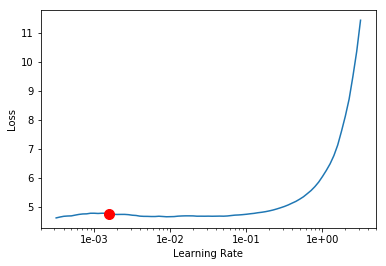

In [20]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [21]:
learn.fit_one_cycle(1, best_lm_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.286894,4.095900,0.324444,1:21:11


In [17]:
learn = learn.load('lm_freezed_2')

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-04


0.00031622776601683783

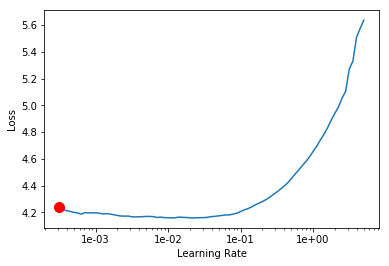

In [19]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [20]:
learn.fit_one_cycle(1, best_lm_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.881428,3.789793,0.347150,43:26


In [22]:
learn.save('lm_unfreezed_2')
learn.save_encoder('lm_enc_unfreezed_2')

In [9]:
learn = learn.load('lm_unfreezed_2')

In [9]:
# data_clas.save(DATA_PATH/'data_clas_export.pkl')
data_clas = load_data(DATA_PATH, 'data_clas_export.pkl', bs=32)

In [12]:
data_clas.show_batch()

text,target
"xxbos xxfld 1 xxmaj inauguration xxmaj day : xxmaj live xxmaj coverage xxfld 2 xxup jan . 20 , 2017 xxmaj alan xxmaj rappeport xxmaj washington xxmaj correspondent xxunk xxup pm xxup et xxmaj welcome ! xxmaj we will starting our live analysis and coverage of the inauguration ceremonies starting around 10 a.m. xxmaj friday morning . xxmaj please check back then to join us . xxmaj morrigan mccarthy 9:31",news
xxbos xxfld 1 2017 xxup nba xxmaj power xxmaj rankings : xxmaj stacking xxmaj up xxmaj all 30 xxmaj teams xxmaj before the xxmaj home xxmaj stretch xxfld 2 xxmaj you know we 're hitting the stretch run when high - end xxup nba teams are surpassing last season 's win totals and clinching playoff spots : xxmaj the xxmaj houston xxmaj rockets and xxmaj golden xxmaj state xxmaj warriors,news
"xxbos xxfld 1 xxmaj david xxmaj pogue tested 40 xxmaj bluetooth earbuds to find the best of the best xxfld 2 xxmaj more xxmaj try xxmaj yahoo xxmaj finance on xxmaj firefox » xxmaj admit it , my people : the way of the world is to go wireless . xxmaj first phone cords went away , then internet cables , then printer cords ; power cords ' extinction is",news
"xxbos xxfld 1 i xxmaj quit xxmaj sugar xxmaj for 30 xxmaj days xxmaj and xxmaj this xxmaj is xxmaj what xxmaj happened xxfld 2 xxmaj log in or sign up to create your own posts . xxmaj no added sugars , no artificial sweeteners , no fake sugars , no honey , no agave , no syrup , no joy . i honestly wish the above statement were a",clickbait
"xxbos xxfld 1 xxmaj what 's xxmaj it xxmaj like xxmaj being xxmaj black in the xxmaj white - xxmaj dominated xxmaj weed xxmaj industry xxfld 2 xxmaj not everyone can be xxmaj wiz xxmaj khalifa , xxmaj snoop xxmaj dogg or xxmaj freddie xxmaj gibbs . xxmaj we 're not just talking about the money , fame , and musical talent , but the fact that all three are",news


In [10]:
len(data_clas.vocab.stoi)

60002

In [14]:
len(data_clas.vocab.itos)

60002

In [15]:
vocab_df = pd.DataFrame(data_clas.vocab.itos, columns=['token'])
vocab_df['token_length'] = vocab_df['token'].str.len()
vocab_df.head()

,token,token_length
0,xxunk,5
1,xxpad,5
2,xxbos,5
3,xxeos,5
4,xxfld,5


In [18]:
vocab_df[vocab_df['token_length'] > 20]['token'].values

array(['sportstips@complex.com', 'pricewaterhousecoopers', 'igcolonel@hotmail.com', 'www.itscanadatime.com',
       'christmascatsofinstagram', 'newunitedairlinesmottos', 'awrhawkins@breitbart.com', 'bookshop.theguardian.com',
       'entertainment.news@bbc.co.uk', 'static1.squarespace.com', '584086c7be6594762f5ec56e',
       '5877e24a29687f9613e546ff', 'wmw+guiding+vision+%26+definition+of+principles.pdf', 'dhowley@yahoo-inc.com',
       'channel_14,channelname', 'wpmagazine@washpost.com', 'womensmarchonwashington', 'haveyoursay@bbc.co.uk',
       'channel_2,channelname', 'newsletters@theatlantic', 'ontheroad@cbsnews.com',
       'ayw_2tf4a1fewxfhv1bys3p8mu95skfbcvz5unjkyozlzotrcjtvgk_6ndbep1imtauws83wewrm_md9nxhr',
       'tciccotta@breitbart.com', 'holyfuckhsjdfds@l??!dsjfas!!sfjmfnksemrewlkf23i', 'yhtruestories@yahoo.com',
       'tanya.chen@buzzfeed.com', 'nextvideo.description', 'psillitoe@bloomberg.net'], dtype=object)

In [19]:
dup_df = full_train_df[full_train_df.duplicated(keep=False)].sort_values('title').head()
dup_df

,title,text,label
350,Hong Kong's New Leader Will Inherit a Fragile ...,Hong Kong's next chief executive -- to be sele...,news
7277,Hong Kong's New Leader Will Inherit a Fragile ...,Hong Kong's next chief executive -- to be sele...,news
24233,xxempty,xxempty,other
23221,xxempty,xxempty,other
22831,xxempty,xxempty,other


In [20]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)

In [20]:
learn_clas.load_encoder('lm_enc_unfreezed_2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.24E-03


0.0022387211385683403

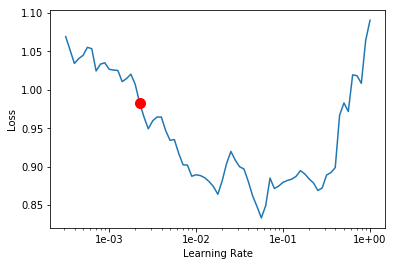

In [21]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [22]:
learn_clas.fit_one_cycle(1, best_clf_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.475150,0.369563,0.851565,59:24


In [24]:
learn_clas.save('clf_freezed_2')
learn_clas.save_encoder('clf_enc_freezed_2')

In [ ]:
learn_clas = learn_clas.load('clf_freezed_2')

In [ ]:
learn_clas.freeze_to(-2)

In [ ]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [ ]:
learn_clas.fit_one_cycle(1, slice(best_clf_lr/2.6**4, best_clf_lr), moms=(0.8, 0.7))

In [ ]:
learn_clas.save('clf_unfreezed_2_2')
learn_clas.save_encoder('clf_enc_unfreezed_2_2')

In [ ]:
learn_clas.unfreeze()

In [ ]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [ ]:
learn_clas.fit_one_cycle(1, slice(best_clf_lr/2.6**4, best_clf_lr), moms=(0.8, 0.7))

In [ ]:
learn_clas.save('clf_unfreezed_all_2')
learn_clas.save_encoder('clf_enc_unfreezed_all_2')

In [ ]:
learn_clas.show_results()

In [40]:
test_preds = []

for batch in tqdm_notebook(learn_clas.data.test_dl):
    test_preds.append(learn_clas.pred_batch(batch))
    
len(test_preds)

353

In [67]:
test_pred_df = pd.DataFrame(torch.cat(test_preds), columns=['clickbait', 'news', 'other'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label').map({0: 'clickbait', 1: 'news', 2: 'other'})

In [48]:
ulmfit_preds.to_csv('ulmfit_predictions_title.csv', index_label='id', header=True)

In [49]:
!head 'ulmfit_predictions_title.csv'

id,label
0,news
1,news
2,news
3,news
4,news
5,news
6,news
7,news
8,news


In [50]:
!wc -l ulmfit_predictions_title.csv

5649 ulmfit_predictions_title.csv


In [42]:
!kaggle competitions submit -c dlinnlp-spring-2019-clf -f ulmfit_predictions_title.csv -m "ULMFiT Baseline"

100%|██████████████████████████████████████| 56.9k/56.9k [00:05<00:00, 11.3kB/s]
Successfully submitted to DL in NLP Spring 2019. Classification